In [56]:
import numpy as np
import keras as k
import tensorflow as tf
from tensorflow.keras import backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
train_path = 'G:/AI_INTRO/DEEPLIZARD/dogs-vs-cats/train'
valid_path = 'G:/AI_INTRO/DEEPLIZARD/dogs-vs-cats/valid'
test_path = 'G:/AI_INTRO/DEEPLIZARD/dogs-vs-cats/test'

In [58]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dog','cat'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dog','cat'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dog','cat'], batch_size=10)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [59]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims= np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


C:\Users\h\anaconda3\envs\tf-new\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


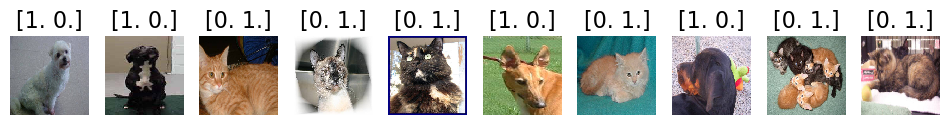

In [60]:
imgs, labels = next(train_batches)

# we plot these samples of images and their labels 1 batch at a time.
plots(imgs, titles=labels)

## Build Fined Tuned VGG16

In [61]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [62]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [63]:
type(vgg16_model)

keras.engine.functional.Functional

#### Converting the model to a sequential model for our better purpose as we ccan see in previous cell the model was not sequential

In [64]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [65]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [66]:
type(model)

keras.engine.sequential.Sequential

In [67]:
model.pop()
# this isdone to pop the last layer. Cause this model outputs 1000 categories. but we need two(cats & dogs).
# so we will add the last layer seperately to get our output in two.

In [68]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [69]:
for layer in model.layers:
    layer.trainable = False  

In [70]:
model.add(Dense(2, activation='softmax'))

In [71]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

## Train model

In [72]:
model.compile(Adam(learning_rate=.0001), loss="categorical_crossentropy", metrics=['accuracy'])

In [73]:
model.fit_generator(train_batches, steps_per_epoch=40,
                   validation_data=valid_batches, validation_steps = 10, epochs = 10, verbose = 2)

Epoch 1/10


C:\Users\h\anaconda3\envs\tf-new\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


40/40 - 6s - loss: 0.7708 - accuracy: 0.6450 - val_loss: 0.3778 - val_accuracy: 0.8300
Epoch 2/10
40/40 - 6s - loss: 0.2208 - accuracy: 0.9300 - val_loss: 0.3657 - val_accuracy: 0.8500
Epoch 3/10
40/40 - 5s - loss: 0.2123 - accuracy: 0.9200 - val_loss: 0.2198 - val_accuracy: 0.9200
Epoch 4/10
40/40 - 6s - loss: 0.1916 - accuracy: 0.9400 - val_loss: 0.2588 - val_accuracy: 0.8600
Epoch 5/10
40/40 - 5s - loss: 0.1313 - accuracy: 0.9450 - val_loss: 0.2416 - val_accuracy: 0.8700
Epoch 6/10
40/40 - 5s - loss: 0.1196 - accuracy: 0.9525 - val_loss: 0.2252 - val_accuracy: 0.9000
Epoch 7/10
40/40 - 5s - loss: 0.1170 - accuracy: 0.9500 - val_loss: 0.1676 - val_accuracy: 0.9100
Epoch 8/10
40/40 - 6s - loss: 0.1025 - accuracy: 0.9625 - val_loss: 0.1615 - val_accuracy: 0.9100
Epoch 9/10
40/40 - 6s - loss: 0.0678 - accuracy: 0.9750 - val_loss: 0.1926 - val_accuracy: 0.9200
Epoch 10/10
40/40 - 6s - loss: 0.0646 - accuracy: 0.9800 - val_loss: 0.1627 - val_accuracy: 0.9100


## Predict using fine-tuned VGG16 model

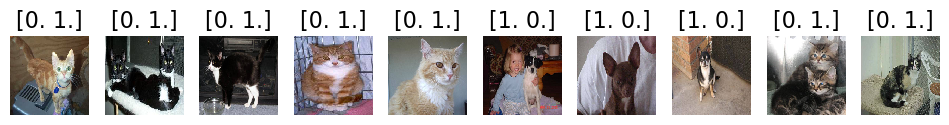

In [74]:
test_img, test_labels = next(test_batches)
plots(test_img, titles = test_labels)

In [75]:
test_labels = test_labels[:,0]
test_labels

array([0., 0., 0., 0., 0., 1., 1., 1., 0., 0.], dtype=float32)

In [76]:
predictions = model.predict_generator(test_batches, steps=1, verbose = 0)

C:\Users\h\anaconda3\envs\tf-new\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [77]:
predictions

array([[5.0235679e-04, 9.9949765e-01],
       [1.5388137e-03, 9.9846125e-01],
       [7.3677354e-04, 9.9926323e-01],
       [9.3356967e-03, 9.9066424e-01],
       [2.9261920e-03, 9.9707377e-01],
       [8.8058537e-01, 1.1941456e-01],
       [9.5237160e-01, 4.7628447e-02],
       [5.7929558e-01, 4.2070439e-01],
       [1.8685772e-04, 9.9981314e-01],
       [8.0287500e-05, 9.9991965e-01]], dtype=float32)

In [78]:
p64= predictions.astype('int64')
p_round = predictions.round()

In [79]:
cm_p64 = confusion_matrix(test_labels, p64[:,0])
cm_round = confusion_matrix(test_labels, p_round[:,0])

In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[7 0]
 [0 3]]


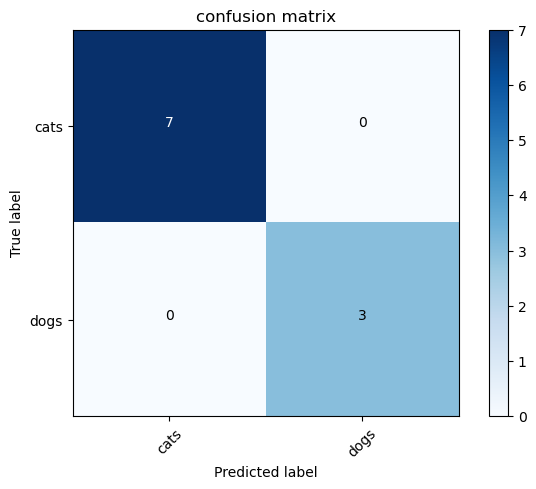

In [81]:
cm_plot_labels = ["cats", "dogs"]
plot_confusion_matrix(cm_round, cm_plot_labels, title="confusion matrix")